In [1]:
# Notebook to evaluate effectiveness of P(k) taylor series
import numpy as np
import sys

from matplotlib import pyplot as plt

In [2]:
sys.path.append(
    '/global/u1/s/sfschen/Python/velocileptors/')

from compute_pell_tables import compute_pell_tables, kvec

140.86304577193016 1559.5181926915848


In [3]:
import json
# Let's reproduce things by reloading the saved file
json_file = open('emu/boss_z_0.61_pkells.json', 'r')
emu = json.load( json_file )
json_file.close()

In [4]:
from taylor_approximation import taylor_approximate
import time
test_point = [0.28, 0.70, 0.78]

x0s = emu['x0']
derivs0 = [np.array(ll) for ll in emu['derivs0']]
derivs2 = [np.array(ll) for ll in emu['derivs2']]

t1 = time.time()
p0test = taylor_approximate(test_point, x0s, derivs0, order=4)
p2test = taylor_approximate(test_point, x0s, derivs2, order=4)
t2 = time.time()
print(t2-t1)

0.013065338134765625


In [5]:
p0, p2, p4 = compute_pell_tables(test_point, z=0.61, fid_dists=np.loadtxt('fid_dists_z_0.61.txt'))

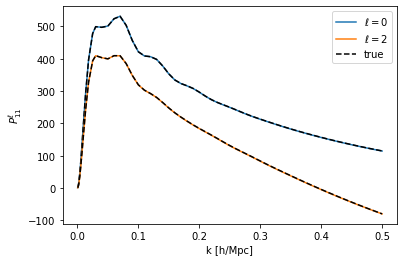

In [6]:
ii = 0

plt.plot(kvec, kvec * p0test[:,ii], label=r'$\ell=0$')
plt.plot(kvec, kvec * p0[:,ii], 'k--')

plt.plot(kvec, kvec * p2test[:,ii], label=r'$\ell=2$')
plt.plot(kvec, kvec * p2[:,ii], 'k--', label='true')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$P^\ell_{11}$')
plt.legend()

Text(0, 0.5, '$\\Delta P_\\ell /P_\\ell$')

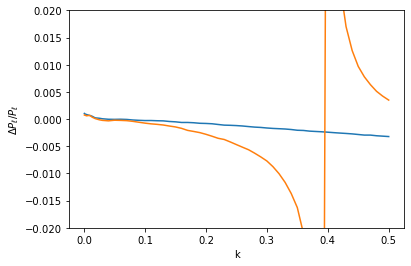

In [7]:
plt.plot(kvec, p0test[:,ii]/p0[:,ii]-1)
plt.plot(kvec, p2test[:,ii]/p2[:,ii]-1)

plt.ylim(-0.02,0.02)
plt.xlabel('k')
plt.ylabel(r'$\Delta P_\ell /P_\ell$')

In [8]:
def combine_bias_terms_pkell(bvec, p0ktable, p2ktable):
    '''
    Same as function above but for the multipoles.
        
    Returns k, p0, p2, p4, assuming AP parameters from input p{ell}ktable
    '''
    
    b1,b2,bs,b3,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4 = bvec

    bias_monomials = np.array([1, b1, b1**2,\
                              b2, b1*b2, b2**2, bs, b1*bs, b2*bs, bs**2, b3, b1*b3,\
                              alpha0, alpha2, alpha4,alpha6,sn,sn2,sn4])

    p0 = np.sum(p0ktable * bias_monomials,axis=1)
    p2 = np.sum(p2ktable * bias_monomials,axis=1)
        
    return p0, p2

In [9]:
# Pull a bunch of parameters out of a chain
mcmc = np.loadtxt('../boss_analysis_joint/chains/bossz1_pk_lnA.2.txt')
mcmc = mcmc[ int(mcmc.shape[0]/2):, :]

In [10]:
iis = np.random.choice(mcmc.shape[0],100, replace=False)

In [11]:
1

1

In [12]:
p0tts = []
p2tts = []

p0s = []
p2s = []

for ii in iis[:100]:
    
    H0, OmM, sigma8 = mcmc[ii, [2,3,-5]]
    bsig8, b2, bs, alpha0, alpha2, sn0, sn2 = mcmc[ii,5:12]
    b1 = bsig8 / sigma8 - 1
    bvec = [b1,b2,bs,0,alpha0,alpha2,0,0,sn0,sn2,0]
    
    test_point = [OmM, H0/100, sigma8]
    
    p0test = taylor_approximate(test_point, x0s, derivs0, order=4)
    p2test = taylor_approximate(test_point, x0s, derivs2, order=4)
    
    p0table, p2table, p4table = compute_pell_tables(test_point, z=0.61, fid_dists=np.loadtxt('fid_dists_z_0.61.txt'))
    
    p0tt, p2tt = combine_bias_terms_pkell(bvec, p0test, p2test)
    p0, p2 = combine_bias_terms_pkell(bvec, p0table, p2table)
    
    p0tts += [p0tt,]
    p2tts += [p2tt,]
    
    p0s += [p0,]
    p2s += [p2,]
    
    #plt.plot(kvec, kvec * p0tt, 'C0')
    #plt.plot(kvec, kvec * p0, 'k--')

In [13]:
p0s = np.array(p0s)
p2s = np.array(p2s)

In [14]:
# import covariance
kerrs = np.arange(0,0.4,0.01)
cov = np.loadtxt('../boss_data_renorm/covariances/C_2048_BOSS_DR12_NGC_z3_V6C_1_1_1_1_1_10_200_200_prerecon.matrix.gz')
errs = np.diag(cov)**0.5
err0 = errs[:40]
err2 = errs[80:120]

In [15]:
dP0s = []
dP2s = []

for ii in range(100):
    
    dP0s += [p0tts[ii]-p0s[ii],]
    dP2s += [p2tts[ii]-p2s[ii],]
    
dP0s = np.array(dP0s)
dP2s = np.array(dP2s)

In [16]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

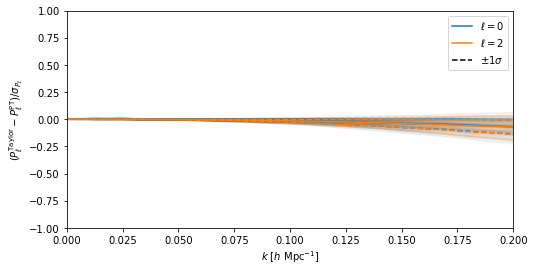

In [19]:
plt.figure(figsize=(8,4))

for ii in range(100):   
    plt.plot(kvec, dP0s[ii,:]/np.interp(kvec,kerrs,err0), 'C0', alpha=0.05)
    plt.plot(kvec, dP2s[ii,:]/np.interp(kvec,kerrs,err2), 'C1', alpha=0.05)
    
mean = np.mean(dP0s,axis=0)
std = np.std(dP0s,axis=0)
    
plt.plot(kvec, mean/np.interp(kvec,kerrs,err0), 'C0',label=r'$\ell=0$')
plt.plot(kvec, (mean+std)/np.interp(kvec,kerrs,err0), 'C0--')
plt.plot(kvec, (mean-std)/np.interp(kvec,kerrs,err0), 'C0--')

mean = np.mean(dP2s,axis=0)
std =  np.std(dP2s,axis=0)
    
plt.plot(kvec, mean/np.interp(kvec,kerrs,err2), 'C1',label=r'$\ell=2$')
plt.plot(kvec, (mean+std)/np.interp(kvec,kerrs,err2), 'C1--')
plt.plot(kvec, (mean-std)/np.interp(kvec,kerrs,err2), 'C1--')

plt.plot(-1000,1000,'k--',label=r'$\pm 1\sigma$')


plt.xlim(0,0.2)
plt.ylim(-1,1)

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel(r'$(P^{\rm Taylor}_\ell - P^{\rm PT}_\ell)/\sigma_{P_\ell}$')
plt.legend()

plt.savefig('../boss_analysis_joint/Figures/ngcz3_taylor_test.pdf')

Text(0, 0.5, '$(P^{\\rm Taylor}_\\ell - P^{\\rm PT}_\\ell)/\\sigma_{P_\\ell}$')

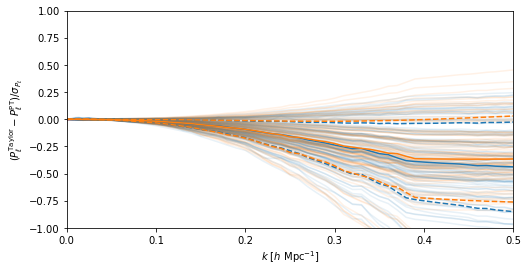

In [106]:
plt.figure(figsize=(8,4))

for ii in range(100):   
    plt.plot(kvec, dP0s[ii,:]/np.interp(kvec,kerrs,err0), 'C0', alpha=0.1)
    plt.plot(kvec, dP2s[ii,:]/np.interp(kvec,kerrs,err2), 'C1', alpha=0.1)

mean0 = np.mean(dP0s,axis=0)
std0 = np.std(dP0s,axis=0)
    
plt.plot(kvec, mean0/np.interp(kvec,kerrs,err0), 'C0')
plt.plot(kvec, (mean0+std0)/np.interp(kvec,kerrs,err0), 'C0--')
plt.plot(kvec, (mean0-std0)/np.interp(kvec,kerrs,err0), 'C0--')

mean = np.mean(dP2s,axis=0)
std =  np.std(dP2s,axis=0)
    
plt.plot(kvec, mean/np.interp(kvec,kerrs,err2), 'C1')
plt.plot(kvec, (mean+std)/np.interp(kvec,kerrs,err2), 'C1--')
plt.plot(kvec, (mean-std)/np.interp(kvec,kerrs,err2), 'C1--')


plt.xlim(0,0.5)
plt.ylim(-1,1)

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel(r'$(P^{\rm Taylor}_\ell - P^{\rm PT}_\ell)/\sigma_{P_\ell}$')

Text(0, 0.5, '$(P^{\\rm Taylor}_\\ell - P^{\\rm PT}_\\ell)/P_\\ell$')

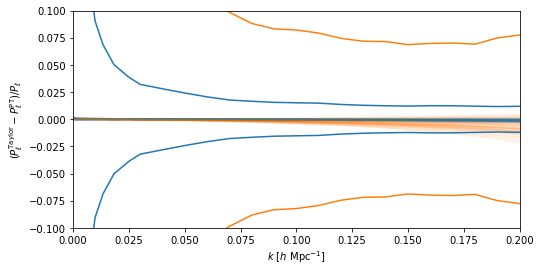

In [129]:
plt.figure(figsize=(8,4))

for ii in range(100):   
    plt.plot(kvec, dP0s[ii,:]/np.mean(p0s,axis=0), 'C0', alpha=0.05)
    plt.plot(kvec, dP2s[ii,:]/np.mean(p2s,axis=0), 'C1', alpha=0.05)
    
mean0 = np.mean(dP0s,axis=0)
std0 = np.std(dP0s,axis=0)
    
#plt.plot(kvec, mean0/np.mean(p0s,axis=0), 'C0')
#plt.plot(kvec, (mean0+std0)/np.mean(p0s,axis=0), 'C0--')
#plt.plot(kvec, (mean0-std0)/np.mean(p0s,axis=0), 'C0--')

plt.plot(kvec, np.interp(kvec,kerrs,err0)/np.mean(p0s,axis=0), 'C0')
plt.plot(kvec, -np.interp(kvec,kerrs,err0)/np.mean(p0s,axis=0), 'C0')


mean = np.mean(dP2s,axis=0)
std =  np.std(dP2s,axis=0)
    
#plt.plot(kvec, mean/np.mean(p2s,axis=0), 'C1')
#plt.plot(kvec, (mean+std)/np.mean(p2s,axis=0), 'C1--')
#plt.plot(kvec, (mean-std)/np.mean(p2s,axis=0), 'C1--')
    
plt.plot(kvec, np.interp(kvec,kerrs,err2)/np.mean(p2s,axis=0), 'C1')
plt.plot(kvec, -np.interp(kvec,kerrs,err2)/np.mean(p2s,axis=0), 'C1')

    
plt.xlim(0,0.2)
plt.ylim(-0.1,0.1)

plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel(r'$(P^{\rm Taylor}_\ell - P^{\rm PT}_\ell)/P_\ell$')

In [128]:
err0

array([12341.41369438,  5889.40859483,  3208.97020704,  1853.17814569,
        1228.88802488,   857.24189181,   642.03214301,   491.62210508,
         392.46845147,   303.96810548,   247.41295646,   213.16298551,
         180.15314499,   157.48859573,   137.99516154,   119.80167777,
         109.61815509,    99.54732827,    89.88883785,    82.06057772,
          78.00484784,    69.16164694,    63.97549603,    59.94471175,
          56.04553939,    52.43130684,    49.71388211,    45.81913088,
          43.5405108 ,    41.36035358,    39.18250846,    37.4682843 ,
          35.71146449,    36.17899932,    33.81756492,    32.4130445 ,
          31.43270269,    29.64473883,    27.71151728,    27.43502584])